In [12]:
import time
import numpy as np
import pandas as pd
import seaborn as sb
import math
from IPython.display import display, clear_output
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

# set random seed to achieve same results each time
np.random.seed(23)

In [13]:
class FacialKeypoints(object):
    
    def __init__(self):
        self.train_csv = pd.read_csv("training.csv")
        self.test_csv = pd.read_csv("test.csv")
        self.sample_csv = pd.read_csv("SampleSubmission.csv")
        self.ID_csv = pd.read_csv("IdLookupTable.csv")
        self.label_names = self.train_csv.columns.tolist()[:-1]
        self.dev_data_n, self.dev_labels_n, self.train_data_n, self.train_labels_n = self.create_training(self.train_csv)
        self.dev_data, self.dev_labels, self.train_data, self.train_labels = self.create_training(self.train_csv, nans=False)
        self.knn = self.K_nn(self.train_data, self.train_labels)
        self.mlp, self.label_scaler, self.data_scaler = self.MLPRegressor(self.train_data, self.train_labels)
    
    def create_training(self, train_csv, dev_size=1000, nans=True):
        if nans == False:
            train_csv = train_csv.dropna()
        labels = train_csv.loc[:, train_csv.columns != 'Image'].values   # column Image is the image data
        data = train_csv['Image'].str.split()                            # image data comes as one long string
        data = np.vstack(data.apply(lambda row: np.asarray([int(n) for n in row])).values)
        data = data/255.0                                                # Rescale grayscale values to [0,1].
        shuffle = np.random.permutation(np.arange(data.shape[0]))        # Shuffle the data
        data, labels              = data[shuffle], labels[shuffle]       
        dev_data, dev_labels      = data[:dev_size], labels[:dev_size]   # Splitting into dev and training
        train_data, train_labels  = data[dev_size:], labels[dev_size:]
        return dev_data, dev_labels, train_data, train_labels
    
    def plot_example(self, data, label, predicted_label=np.nan):
        plt.imshow(data.reshape(96, 96), cmap='gray')
        plt.scatter(label[0::2], label[1::2], c='red', marker='x', label='actual')
        if np.all(np.isfinite(predicted_label)):
            plt.scatter(predicted_label[0::2], predicted_label[1::2], c='blue', marker='x', label='predicted')
        plt.axis('off')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
        return
    
    def score(self, y_pred, y_actual):
        return np.sqrt(mean_squared_error(y_actual, y_pred))
    
    def preprocessor(self):
        # label_nan_filler() generates a substitute value for each missing facial keypoint as the average distance from the
        # facial keypoint to the origin, scaling each distance by each image keypoints' Euclidean norm prior to
        # averaging, then descaling for the final value    
        def label_nan_filler():
            # the line below returns a list of the number of missing label values for each facial keypoint
            train_label_nan_counts = np.count_nonzero(np.isnan(self.train_labels_n), axis = 0)
    
            # get the indices of keypoints that have no missing label values, these will be the origin
            origin_index = [i for i, x in enumerate(train_label_nan_counts) if x == 0]

            # extract the label origin values for each image using the origin index
            origin_x = self.train_labels_n[:, origin_index[0]]
            origin_y = self.train_labels_n[:, origin_index[1]]

            # separate x labels from y labels
            x_keypoints = self.train_labels_n[:,0::2]
            y_keypoints = self.train_labels_n[:,1::2]

            # get the distance between each point and the origin
            x_keypoint_dist_from_origin = np.empty((x_keypoints.shape))
            y_keypoint_dist_from_origin = np.empty((y_keypoints.shape))
            for i in range(x_keypoints.shape[0]):
                for j in range(x_keypoints.shape[1]):
                    x_keypoint_dist_from_origin[i,j] = x_keypoints[i,j] - origin_x[i]
                    y_keypoint_dist_from_origin[i,j] = y_keypoints[i,j] - origin_y[i]

            # get the Euclidean norm of each distance from origin (with as many non-nan values as possible) to use as
            # a scaling factor
            label_norms = np.empty(len(self.train_labels_n))
            for i in range(len(self.train_labels_n)):
                label_norms[i] = np.linalg.norm(np.hstack((x_keypoint_dist_from_origin[i, ~np.isnan(x_keypoint_dist_from_origin[i])],
                                                           y_keypoint_dist_from_origin[i, ~np.isnan(y_keypoint_dist_from_origin[i])])))

            # scale each facial keypoint distance from origin by the Eucliean norm of its associated face
            x_scaled_dist_from_origin = np.empty((x_keypoints.shape))
            y_scaled_dist_from_origin = np.empty((y_keypoints.shape))
            for i in range(len(self.train_labels_n)):
                for j in range(int(len(self.label_names)/2)):
                    x_scaled_dist_from_origin[i,j] = x_keypoint_dist_from_origin[i,j]/label_norms[i]
                    y_scaled_dist_from_origin[i,j] = y_keypoint_dist_from_origin[i,j]/label_norms[i]
            
            # take the mean of each scaled facial keypoint across all faces
            x_mean_scaled_dist_from_origin = np.nanmean(x_scaled_dist_from_origin, axis=0)
            y_mean_scaled_dist_from_origin = np.nanmean(y_scaled_dist_from_origin, axis=0)
            
            # combine the x and y mean scaled distances from the origin into the original label order
            mean_scaled_dist_from_origin = np.empty(30)
            x_iter = iter(x_mean_scaled_dist_from_origin)
            y_iter = iter(y_mean_scaled_dist_from_origin)
            for i in range(len(mean_scaled_dist_from_origin)):
                if i%2 == 0:
                    mean_scaled_dist_from_origin[i] = next(x_iter)
                else:
                    mean_scaled_dist_from_origin[i] = next(y_iter)
            
            # adjustable scale factor (multiplied by norm of labels)
            s_f = 2.2
            # adjustable y offset, since noses on images w/ missing values tend to be labeled at a vertical offset
            y_off = -7
            
            # substitute missing values for average values
            filled_in_train_labels = np.empty((self.train_labels_n).shape)
            # check for nan values
            for row in range(len(self.train_labels_n)):
                for label_index in range(len(self.label_names)):
                    if math.isnan(self.train_labels_n[row, label_index]):
                        # add de-scaled mean distance from x or y origin for average facial keypoint position to each NaN
                        if label_index%2 == 0:
                            filled_in_train_labels[row, label_index] = origin_x[row] + (mean_scaled_dist_from_origin[label_index] *s_f*label_norms[row])
                        else:
                            filled_in_train_labels[row, label_index] = origin_y[row] + y_off +(mean_scaled_dist_from_origin[label_index] *s_f*label_norms[row])
                    # fill the rest of the array with the original label values
                    else:
                        filled_in_train_labels[row, label_index] = self.train_labels_n[row, label_index]
            
            # return array with no NaN values
            return filled_in_train_labels
        
        preprocessed_data = label_nan_filler()
        return preprocessed_data
    
    def K_nn(self, data, labels, n_neighbors=3):
        knn = KNeighborsRegressor(n_neighbors)
        knn.fit(data, labels)
        return knn
    
    def MLPRegressor(self, data, labels):
        label_scaler, data_scaler = StandardScaler(), StandardScaler()
        label_scaler.fit(labels)
        data_scaler.fit(data)
        mlp = MLPRegressor(hidden_layer_sizes=(300, 100), early_stopping=True)
        mlp.fit(data_scaler.transform(data), label_scaler.transform(labels))
        return mlp, label_scaler, data_scaler
    
    def blur_data(self, data):
        data = data.reshape(data.shape[0], int(data.shape[1]**0.5), -1) 
        data = np.array([np.roll(np.roll(data, horizontal, axis=1), 
                                               vertical  , axis=2) 
                         for vertical in range(-1,2) for horizontal in range(-1,2)]
                       ).mean(axis=0)     
        return data.reshape(data.shape[0], -1)
    
    ## Various Methods to Create More Training Examples
    def _average_nans(self, train_labels):
        df = pd.DataFrame(train_labels)
        return df.fillna(df.mean()).values
    
    def _gaussianMM_nans(self, train_labels):
        return
    
    pass

## Initialize the Object

In [14]:
self = FacialKeypoints()

## Missing Labels

We noticed that there are many examples that are missing a full label set. Out of the total 6049 examples, only 1140 have the full set of labels. Here is the percentage break out of each label

In [16]:
(self.train_csv.loc[:, self.train_csv.columns != 'Image'].count()/len(self.train_csv.index)).round(3)

left_eye_center_x            0.999
left_eye_center_y            0.999
right_eye_center_x           0.998
right_eye_center_y           0.998
left_eye_inner_corner_x      0.322
left_eye_inner_corner_y      0.322
left_eye_outer_corner_x      0.322
left_eye_outer_corner_y      0.322
right_eye_inner_corner_x     0.322
right_eye_inner_corner_y     0.322
right_eye_outer_corner_x     0.322
right_eye_outer_corner_y     0.322
left_eyebrow_inner_end_x     0.322
left_eyebrow_inner_end_y     0.322
left_eyebrow_outer_end_x     0.316
left_eyebrow_outer_end_y     0.316
right_eyebrow_inner_end_x    0.322
right_eyebrow_inner_end_y    0.322
right_eyebrow_outer_end_x    0.317
right_eyebrow_outer_end_y    0.317
nose_tip_x                   1.000
nose_tip_y                   1.000
mouth_left_corner_x          0.322
mouth_left_corner_y          0.322
mouth_right_corner_x         0.322
mouth_right_corner_y         0.322
mouth_center_top_lip_x       0.323
mouth_center_top_lip_y       0.323
mouth_center_bottom_

#### Plot an Example From Incomplete Labels

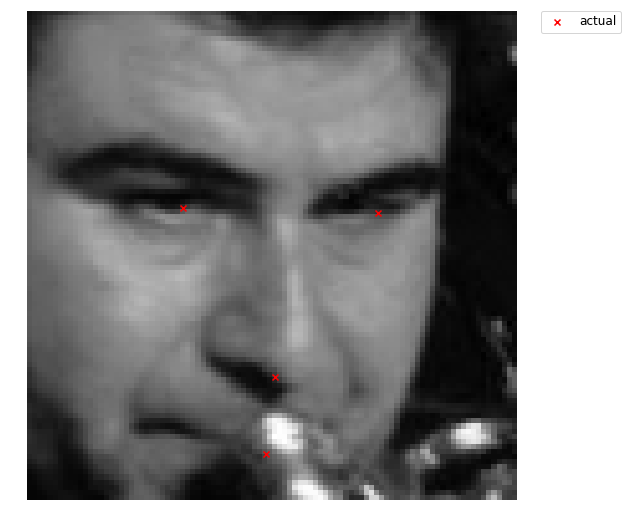

In [17]:
self.plot_example(self.train_data_n[1], self.train_labels_n[1]) 

#### Plot an Example From Complete Labels

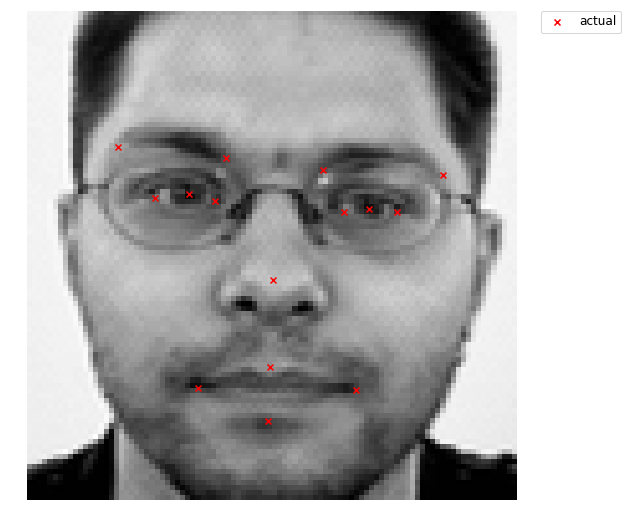

In [18]:
self.plot_example(self.train_data[25], self.train_labels[25]) 

## Preprocess the Data

In [19]:
preprocessed_train_labels = self.preprocessor()

#### Plot an Example From Incomplete Labels

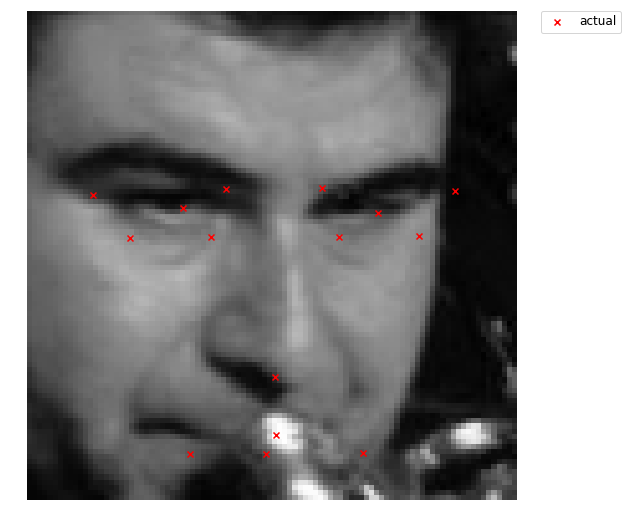

In [20]:
self.plot_example(self.train_data_n[1], preprocessed_train_labels[1]) 

## K-NN

#### Using only the training data with complete set of labels

In [21]:
y_pred = self.knn.predict(self.dev_data) 

In [22]:
self.score(self.dev_labels, y_pred)

2.5699609194515616

#### Using blurring and _average_ _nans_

blur_data rolls shifts the image 1 pixel in each direction and takes the mean, effectively returning a blurred image

In [28]:
self.knn = self.K_nn(data=self.blur_data(self.train_data_n), labels=self._average_nans(self.train_labels_n))
y_pred = self.knn.predict(self.dev_data)
self.score(self.dev_labels, y_pred)

1.8606199509164483

#### Using _label_ _nan_ _filler_

In [29]:
self.knn = self.K_nn(data=self.blur_data(self.train_data_n), labels=preprocessed_train_labels)
y_pred = self.knn.predict(self.dev_data)
self.score(self.dev_labels, y_pred)

2.0862258533073339

#### Plot a Prediction

RMSE of 1.96408224243


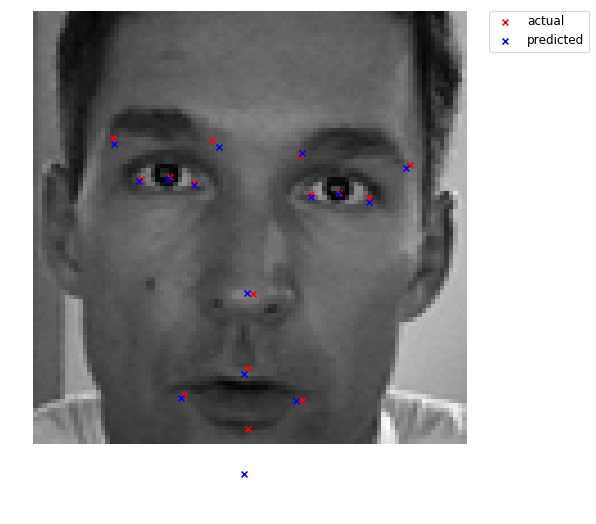

In [30]:
example_num = 25
print ('RMSE of '+ str((self.score(self.dev_labels[example_num], y_pred[example_num]))))

self.plot_example(self.dev_data[example_num], self.dev_labels[example_num], y_pred[example_num])

## Neural Net

#### Standard Scale Training and Labels

In [31]:
y_pred = self.mlp.predict(self.data_scaler.transform(self.dev_data))
self.score(self.dev_labels, self.label_scaler.inverse_transform(y_pred))

2.9035010245112907

#### Using _average_nans to preprocess and create more training data

In [32]:
self.mlp, self.label_scaler, self.data_scaler = self.MLPRegressor(self.train_data_n, 
                                                                  self._average_nans(self.train_labels_n))

In [33]:
y_pred = self.mlp.predict(self.data_scaler.transform(self.dev_data))
self.score(self.dev_labels, self.label_scaler.inverse_transform(y_pred))

2.4950321312632244

#### Using _label_ _nan_ _filler_

In [ ]:
self.mlp, self.label_scaler, self.data_scaler = self.MLPRegressor(self.train_data_n, 
                                                                  preprocessed_train_labels)

In [ ]:
y_pred = self.mlp.predict(self.data_scaler.transform(self.dev_data))
self.score(self.dev_labels, self.label_scaler.inverse_transform(y_pred))

#### Plot a Prediction

RMSE of 2.93486511245


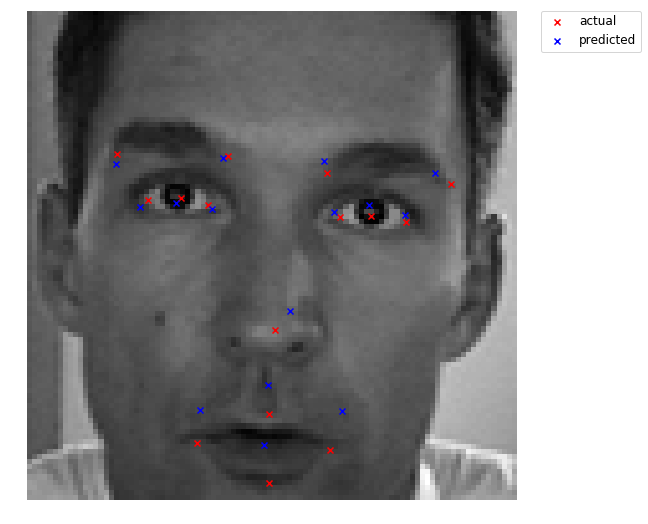

In [34]:
print ('RMSE of '+ str((self.score(self.dev_labels[example_num],
                                   self.label_scaler.inverse_transform(y_pred[example_num])))))

self.plot_example(self.dev_data[example_num], self.dev_labels[example_num], 
                  self.label_scaler.inverse_transform(y_pred[example_num]))

## Grid Search to Find Best Parameters

In [35]:
knn = KNeighborsRegressor()
parameters ={'n_neighbors': range(1, 25)}
clf = GridSearchCV(knn, parameters)
clf.fit(self.train_data, self.train_labels)
clf.best_params_

KeyboardInterrupt: 

## Gaussian MM to Fill NaNs

In [36]:
pd.DataFrame(self.train_labels, columns=self.label_names)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,65.773935,37.185290,30.482323,35.801032,59.892387,38.569548,73.039742,37.185290,37.056774,38.223484,...,48.474581,66.248516,60.237677,80.088000,29.790968,80.088000,46.398194,76.628129,45.666581,87.307355
1,64.086765,39.042362,26.826523,41.848591,56.135839,40.289718,73.596564,40.757477,35.712966,41.848591,...,46.002362,61.180349,62.995329,79.732510,33.841933,80.979544,47.405315,78.017718,48.184913,83.785772
2,65.863283,39.308359,29.256166,36.034428,59.316083,40.201490,73.006345,41.391890,35.804028,37.820028,...,46.329600,61.148028,58.720221,82.463338,34.315697,81.868138,46.815559,77.701738,46.518290,89.903669
3,64.155049,39.615958,29.595049,37.659302,59.263410,42.004898,74.776505,41.599006,38.286241,40.730797,...,47.279105,56.733746,61.531007,78.108229,30.929822,75.889928,46.531876,76.032885,46.268334,76.970639
4,64.941283,34.686792,24.871245,35.496453,58.464906,35.496453,71.416755,35.091623,31.752453,35.901283,...,47.537208,55.329509,61.703547,77.185811,30.942792,76.376151,46.090868,73.310491,45.707774,81.424302
5,66.662400,36.729934,27.863374,37.849127,60.693704,37.849127,74.869983,38.222191,34.578365,38.222191,...,50.029357,56.372870,67.408696,71.052522,28.982817,72.917426,49.501774,67.695026,49.377391,86.683826
6,64.556883,38.323948,31.404468,40.831169,58.149195,39.437922,70.685922,38.881247,37.533506,41.109818,...,48.120312,50.582026,64.835532,74.540883,33.911688,76.769455,48.676987,68.411844,49.234286,78.162701
7,65.200485,36.823919,29.472970,37.398303,57.851152,37.605818,74.582626,37.918384,37.366949,38.543838,...,48.625455,58.871596,63.793131,79.668364,33.457778,80.763152,48.781899,75.133737,48.781899,84.515879
8,64.429638,38.641905,29.421759,37.894492,57.113747,40.532298,71.780890,39.834069,38.401409,39.957031,...,53.441860,59.456099,63.420598,76.885050,32.231123,77.496133,50.769435,78.394684,51.386047,78.819934
9,66.572250,38.770275,28.697250,38.770275,59.868750,40.110975,72.940500,38.770275,32.718750,39.440625,...,45.456000,63.238500,63.891000,81.338250,30.037500,84.019500,46.797000,74.634750,47.466750,88.712250


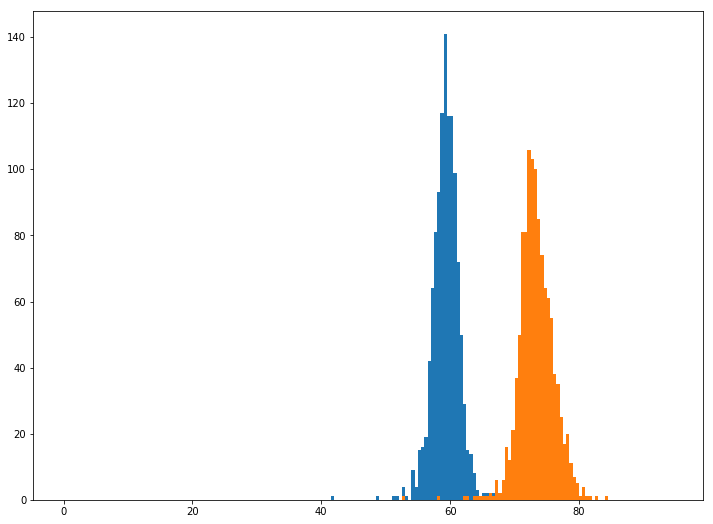

In [37]:
plt.hist(self.train_labels[:, 4], bins=np.arange(35, 95, 0.5));
plt.hist(self.train_labels[:, 6], bins=np.arange(0, 85, 0.5));